<a href="https://colab.research.google.com/github/cilvento/integerpartitionsdemo/blob/master/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Two-stage integer, non-negative histogram Demonstration


In this notebook, we demonstrate the two-stage integer non-negative histogram procedure on the social security administration [Baby Names dataset](https://www.ssa.gov/oact/babynames/limits.html) (1880-1885). This dataset allows us to illustrate the benefits of using historical or public information in the mechanism. In the case of baby names, the *shape* of the histogram stays pretty similar year over year, even if the ordering of the names may change significantly as names become more or less popular. 

For the purposes of the demonstration, we consider the data from 1880-1884 to be public (in addition to the list of all names occuring from 1880-1885). Our goal is to produce a differentially private, integer, non-negative histogram for the name counts for 1885. 
To demonstrate the variety of techniques one could use, we generate bounds in three ways:

  1. **Laplace**: we use a small amount of budget ($\varepsilon_1 \approx 0.1$) to generate noisy estimates of each name count for 1885 and use $\frac{1}{\varepsilon_1}$ for the bound width.
  2. **Historical extrapolation**: we perform a simple linear extrapolation from the 1880-1884 data, and use the predicted values for 1884 and 1886 as the bounds.
  3. **Historical benchmark**: we take the counts for 1884 and set the bounds to $\pm 10\%$. *(This performs surprisingly well!)*

The total privacy budget used is approximately $\varepsilon \approx 4$, with some slush for a factor of $2$ in several places that could be improved.


## Setup

This notebook is setup to use local files as input and assumes that a binary of `ip_demo` is already built. Please see [github](https://github.com/cilvento/innh_demo) for source-code and instructions on how to build the binary. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import datetime

# Reproducibility
np.random.seed(0)

# Figure setup
plt.rcParams['figure.figsize'] = (10.0, 5.0)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

### Dataset Import and Processing

Note: you can store all of the files, etc in Google Drive if you want to run on Colaboratory. You may need to modify paths for your particular setup.

In [ ]:
# If you're using Google Drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

We subtract $4$ from each count, as the dataset only includes names with count at least 5 for a given year as a basic privacy protection. By subtracting 4, we get a smoother tail, rather than dropping off from $5$ to $0$.

Note: Change `fp` to be the path to the count files on your local system. 

In [ ]:
fp = '/content/drive/My Drive/development/datasets/babynames/'
df = pd.read_csv(fp+'yob1880.txt',header=None,names=['name','gender','count1880'],index_col=['name','gender'])
df1 = pd.read_csv(fp+'yob1881.txt',header=None,names=['name','gender','count1881'],index_col=['name','gender'])
df2 = pd.read_csv(fp+'yob1882.txt',header=None,names=['name','gender','count1882'],index_col=['name','gender'])
df3 = pd.read_csv(fp+'yob1883.txt',header=None,names=['name','gender','count1883'],index_col=['name','gender'])
df4 = pd.read_csv(fp+'yob1884.txt',header=None,names=['name','gender','count1884'],index_col=['name','gender'])
df5 = pd.read_csv(fp+'yob1885.txt',header=None,names=['name','gender','count1885'],index_col=['name','gender'])

# join the datasets
dfj = df.join(df1, how='outer')
dfj = dfj.join(df2, how='outer')
dfj = dfj.join(df3, how='outer')
dfj = dfj.join(df4, how='outer')
dfj = dfj.join(df5, how='outer')
# Fix float back to int
dfj = dfj.fillna(0.0)
dfj = dfj[['count1880','count1881','count1882','count1883','count1884','count1885']].applymap(np.int64)
df = dfj
df = df.reset_index()

# Smooth out five-counts
if True:
  df['count1880']=df['count1880'].apply(lambda x:  max(0,x-4))
  df['count1881']=df['count1881'].apply(lambda x:  max(0,x-4))
  df['count1882']=df['count1882'].apply(lambda x:  max(0,x-4))
  df['count1883']=df['count1883'].apply(lambda x:  max(0,x-4))
  df['count1884']=df['count1884'].apply(lambda x:  max(0,x-4))
  df['count1885']=df['count1885'].apply(lambda x:  max(0,x-4))

df['namegender'] = df['name'] + df['gender']
df.fillna(0)
df = df.sort_values(by='name')
df.describe()

,count1880,count1881,count1882,count1883,count1884,count1885
count,3244.000000,3244.000000,3244.000000,3244.000000,3244.000000,3244.000000
mean,59.643650,57.014797,65.667386,64.305795,72.217324,71.417386
std,368.960775,341.751259,382.279869,362.359132,394.879506,378.993221
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,3.000000,2.000000,3.000000,3.000000
75%,14.000000,14.000000,16.000000,16.000000,18.000000,19.000000
max,9651.000000,8765.000000,9553.000000,8890.000000,9384.000000,9124.000000


### Extrapolation
Next we make simple linear extrapolations from 1880-1884 to 1885-1886. We use 1886 and 1884 as the upper and lower bounds for each name.

In [ ]:
predicted_counts84 = []
predicted_counts85 = []
predicted_counts86 = []
for r in df['namegender']:
  row = df[df['namegender'] == r][['count1880','count1881','count1882','count1883','count1884']]
  Y = row.values.reshape(-1,1)
  X = np.asarray([0,1,2,3,4]).reshape(-1,1)
  linreg = LinearRegression()
  linreg.fit(X,Y)
  X_new = np.asarray([0,1,2,3,4,5,6]).reshape(-1,1)
  Ypred = linreg.predict(X_new)
  predicted_counts85.append(Ypred[5][0])
  predicted_counts84.append(Ypred[4][0])
  predicted_counts86.append(Ypred[6][0])
  

df['predicted1885'] = predicted_counts85
df['predicted1884'] = predicted_counts84
df['predicted1886'] = predicted_counts86

In [ ]:
# Construct Bounds
# Historical Extrapolation Bounds
df.head()
df.sort_index()
print(df.head())
def get_pred_upper(row):
  u = int(round(max(0,row['predicted1884'],row['predicted1886'])))
  l = int(round(max(min(row['predicted1884'],row['predicted1886']),0)))
  if u == l:
    u += 1
  return u
def get_pred_lower(row):
  u = int(round(max(0,row['predicted1884'],row['predicted1886'])))
  l = int(round(max(min(row['predicted1884'],row['predicted1886']),0)))
  if u == l:
    l = max(0, l-1)
  return l

df['predicted_upper'] = df.apply (lambda row: get_pred_upper(row), axis=1)
df['predicted_lower'] = df.apply(lambda row: get_pred_lower(row) , axis=1)

### Laplace
For simplicity, we use `numpy` Laplace, although the demo rust code does include the option to do this in a purely differentially private way. (We use bounds files for all three strategies to make comparison and reproducibility easier.)

In [ ]:
# Laplace (approximate-DP)
lap_est = []
lap_lower = []
lap_upper = [] 
bounds_eps = 0.1

def get_lap(row):
  return int(round(max(0,row['count1885']+ np.random.laplace(loc=0, scale=1/bounds_eps))))
def get_lap_upper(row):
  return int(round(max(0,row['laplace_est85']+2/bounds_eps)))
def get_lap_lower(row):
  return int(round(max(0,row['laplace_est85']-2/bounds_eps)))

df['laplace_est85'] = df.apply (lambda row: get_lap(row), axis=1)
df['lap_lower'] = df.apply(lambda row: get_lap_lower(row), axis=1)
df['lap_upper'] = df.apply(lambda row: get_lap_upper(row),axis=1)

### Historical Benchmark
We use the 1884 count $\pm 10\%$ as a simple benchmark. (With a minimum bound width of $1$).


In [ ]:
# 1884 10% offset
def get_hist(row):
  return int(round(max(0,row['count1884'])))

def get_hist_upper(row):
  u = int(round(max(0,row['hist_est']*1.1)))
  l = int(round(max(0,row['hist_est']*.9)))
  if u == l:
    u += 1
  return u 

def get_hist_lower(row):
  u = int(round(max(0,row['hist_est']*1.1)))
  l = int(round(max(0,row['hist_est']*.9)))
  if u == l:
    l = max(0,l-1)
  return l

df['hist_est'] = df.apply (lambda row: get_hist(row), axis=1)
df['hist_lower'] = df.apply(lambda row: get_hist_lower(row), axis=1)
df['hist_upper'] = df.apply(lambda row: get_hist_upper(row),axis=1)

### Generate Test Files
Next we output each set of bounds and the 1885 counts to files for later use.


In [ ]:
# Increase recursion limit
sys.setrecursionlimit(5000)
# You will want to change this path
fp1 = '/content/drive/My Drive/development/datasets/babynames/bounds/'
preddf = pd.DataFrame()
preddf['name'] = df['namegender']
preddf['lower'] = df['predicted_lower']
preddf['upper'] = df['predicted_upper']
estimates = [int(df['predicted1885'][i]) for i in range(0, len(df))]
preddf['estimate'] = df['predicted1885']
preddf = preddf.round(0)
preddf = preddf.fillna(0)
preddf = preddf.astype({'lower': 'int32', 'upper': 'int32', 'estimate':'int32'})
preddf.head()
preddf.to_csv(fp1 + 'predicted_bounds.csv',index=False)

In [ ]:
preddf = pd.DataFrame()
preddf['name'] = df['namegender']
preddf['lower'] = df['hist_lower']
preddf['upper'] = df['hist_upper']
preddf['estimate'] = df['hist_est']
preddf = preddf.round(0)
preddf = preddf.fillna(0)
preddf = preddf.astype({'lower': 'int32', 'upper': 'int32', 'estimate':'int32'})
preddf.head()
preddf.to_csv(fp1 + 'histest_bounds.csv',index=False)

In [ ]:
preddf = pd.DataFrame()
preddf['name'] = df['namegender']
preddf['lower'] = df['lap_lower']
preddf['upper'] = df['lap_upper']
preddf['estimate'] = df['laplace_est85']
preddf = preddf.round(0)
preddf = preddf.fillna(0)
preddf = preddf.astype({'lower': 'int32', 'upper': 'int32', 'estimate':'int32'})
preddf.head()
preddf.to_csv(fp1 + 'lap_bounds.csv',index=False)

In [ ]:
preddf = pd.DataFrame()
preddf['name'] = df['namegender']
preddf['count'] = df['count1885']
preddf.head()
preddf.to_csv(fp1 +'1885_counts.csv',index=False)

## Run Trials
Next, we use the files generated to run 10 trials for each strategy. (Note that this should take less than an hour on Google Colab to run all trials). Make sure that you modify the path to the demo binary/your compiled rust code.

In [ ]:
%%bash 
cd drive/My\ Drive/development/
chmod 777 ./binaries/ip_demo
./binaries/ip_demo  ./datasets/babynames/bounds/1885_counts.csv -b FromFile -f ./datasets/babynames/bounds/lap_bounds.csv -t 10 > ./datasets/babynames/bounds/results/lap_basic.txt 
./binaries/ip_demo  ./datasets/babynames/bounds/1885_counts.csv -b FromFile -f ./datasets/babynames/bounds/predicted_bounds.csv -t 10 > ./datasets/babynames/bounds/results/predicted_basic.txt 
./binaries/ip_demo  ./datasets/babynames/bounds/1885_counts.csv -b FromFile -f ./datasets/babynames/bounds/histest_bounds.csv -t 10 > ./datasets/babynames/bounds/results/histest_basic.txt 
./binaries/ip_demo  ./datasets/babynames/bounds/1885_counts.csv -b FromFile -f ./datasets/babynames/bounds/lap_bounds.csv -a Scoped -t 10 > ./datasets/babynames/bounds/results/lap_scoped.txt 
./binaries/ip_demo  ./datasets/babynames/bounds/1885_counts.csv -b FromFile -f ./datasets/babynames/bounds/predicted_bounds.csv -a Scoped -t 10 > ./datasets/babynames/bounds/results/predicted_scoped.txt 
./binaries/ip_demo  ./datasets/babynames/bounds/1885_counts.csv -b FromFile -f ./datasets/babynames/bounds/histest_bounds.csv -a Scoped -t 10 > ./datasets/babynames/bounds/results/histest_scoped.txt 

## Analysis
Read in the results of the trials and compare the strategies.

First we load in the true counts.

In [ ]:
def parse_counts_file(fname):
  f = open(fname)
  f.readline()
  counts = []
  for line in f:
    c = line.split(',')
    counts.append([c[0],int(c[1])])
  return counts
counts = parse_counts_file(fp + 'bounds/1885_counts.csv')
# First sort by name
counts.sort(key=lambda x: x[0])
# Then by count, to get counts tie-broken consistently by name
counts.sort(key=lambda x: x[1],reverse=True)

true_counts = [x[1] for x in counts]
names = [x[0] for x in counts]


Bounds files (sorted to match the true counts).

In [ ]:
def parse_bounds_file(fname):
  f = open(fname)
  f.readline()
  bounds = []
  for line in f:
    b = line.split(',')
    bounds.append([b[0],int(b[1]),int(b[2]),int(b[3])])
  return bounds
fp = '/content/drive/My Drive/development/datasets/babynames/'
p_bounds = parse_bounds_file(fp+'bounds/predicted_bounds.csv')
l_bounds = parse_bounds_file(fp+'bounds/lap_bounds.csv')
h_bounds = parse_bounds_file(fp+'bounds/histest_bounds.csv')

In [ ]:
p_bounds.sort(key= lambda x: names.index(x[0]))
l_bounds.sort(key= lambda x: names.index(x[0]))
h_bounds.sort(key= lambda x: names.index(x[0]))

Results files.

In [ ]:
''' Output file format is somewhat cryptic. The first 5 lines include
    a trial configuration summary. The sixth line is the bias,
    repeating in triplets afterwards are the true counts, ideal attribution 
    (i.e., if the second stage were perfect), the two-stage mechanism output 
    (i.e., the actual attributed counts.)
'''
def parse_file(fname):
  f = open(fname)
  ideals = []
  attr = []
  count = 0
  for line in f:
    count += 1
    if count == 6:
      bias = line.split(',')
      bias = [float(x) for x in bias[0:len(bias)-1]]
    if count > 6 and count % 3 == 2:
      splitline = line.split(',')
      ideals.append([int(x) for x in splitline[0:len(splitline) -1 ]])
    elif count > 6 and count % 3 == 0:
      splitline = line.split(',')
      attr.append([int(x) for x in splitline[0:len(splitline) -1 ]])
  return bias, ideals, attr

In [ ]:
# read in files
plt.rcParams.update({'font.size': 18})
fp = '/content/drive/My Drive/development/datasets/babynames/'
ls_bias, ls_ideal, ls_attr = parse_file(fp + 'bounds/results/lap_scoped.txt')
lb_bias, lb_ideal, lb_attr = parse_file(fp + 'bounds/results/lap_basic.txt')
ps_bias, ps_ideal, ps_attr = parse_file(fp + 'bounds/results/predicted_scoped.txt')
pb_bias, pb_ideal, pb_attr = parse_file(fp + 'bounds/results/predicted_basic.txt')
hs_bias, hs_ideal, hs_attr = parse_file(fp + 'bounds/results/histest_scoped.txt')
hb_bias, hb_ideal, hb_attr = parse_file(fp + 'bounds/results/histest_basic.txt')

Pretty formatting setup :)

In [ ]:
hs_color = (0.9677975592919913, 0.44127456009157356, 0.5358103155058701) 
ls_color =  (0.7350228985632719, 0.5952719904750953, 0.1944419133847522)
p_color = (0.3126890019504329, 0.6928754610296064, 0.1923704830330379)
ps_color = (0.21044753832183283, 0.6773105080456748, 0.6433941168468681)
l_color = (0.23299120924703914, 0.639586552066035, 0.9260706093977744)
h_color =  (0.9082572436765556, 0.40195790729656516, 0.9576909250290225)
l_label = "Laplace "
h_label = "Historical "
p_label = "Extrapolated "

### Bounds Visualization

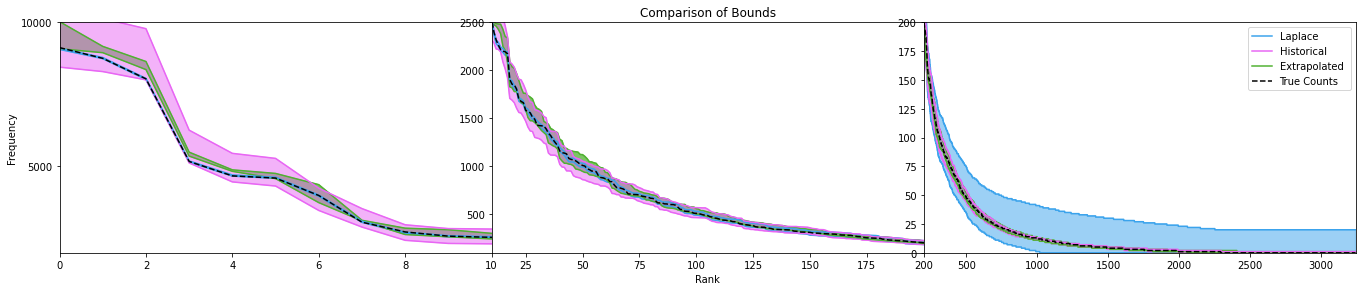

In [ ]:
x = np.arange(0, 3244, 1) # Ranks
l_lower = [l_bounds[i][1] for i in range(0, len(x))]
l_lower.sort(reverse=True)
l_upper = [l_bounds[i][2] for i in range(0, len(x))]
l_upper.sort(reverse=True)
l_y1 = l_lower
l_y2 = l_upper

p_lower = [p_bounds[i][1] for i in range(0, len(x))]
p_lower.sort(reverse=True)
p_upper = [p_bounds[i][2] for i in range(0, len(x))]
p_upper.sort(reverse=True)
p_y1 = p_lower
p_y2 = p_upper


h_lower = [h_bounds[i][1] for i in range(0, len(x))]
h_lower.sort(reverse=True)
h_upper = [h_bounds[i][2] for i in range(0, len(x))]
h_upper.sort(reverse=True)
h_y1 = h_lower
h_y2 = h_upper


fig = plt.figure()

ax1 = fig.add_axes([0.1, 0.1, 1.0, 0.8])
ax2 = fig.add_axes([1.1, 0.1, 1.0, 0.8])
ax3 = fig.add_axes([2.1, 0.1, 1.0, 0.8])
#ax4 = fig.add_axes([1.3, 0.1, 0.4, 0.8])

ax1.fill_between(x, l_y1, l_y2, color=l_color,alpha=0.5)
ax1.fill_between(x, p_y1, p_y2, color=p_color,alpha=0.75)
ax1.fill_between(x, h_y1, h_y2, color=h_color,alpha=.5)

ax1.plot(x,l_lower,c=l_color,label=l_label)
ax1.plot(x,h_lower,c=h_color,label=h_label)
ax1.plot(x,p_lower,c=p_color,label=p_label)
ax1.plot(x,p_upper,c=p_color)
ax1.plot(x,l_upper,c=l_color)
ax1.plot(x,h_upper,c=h_color)
ax1.plot(x,true_counts,c='k',linestyle='--',label="True Counts")
ax1.set_xlim(0,10)
ax1.set_ylim(2000,10000)
ax1.set_yticks([5000,10000])

ax2.fill_between(x, l_y1, l_y2, color=l_color,alpha=0.5)
ax2.fill_between(x, p_y1, p_y2, color=p_color,alpha=0.75)
ax2.fill_between(x, h_y1, h_y2, color=h_color,alpha=.5)

ax2.plot(x,l_lower,c=l_color,label=l_label)
ax2.plot(x,h_lower,c=h_color,label=h_label)
ax2.plot(x,p_lower,c=p_color,label=p_label)
ax2.plot(x,p_upper,c=p_color)
ax2.plot(x,l_upper,c=l_color)
ax2.plot(x,h_upper,c=h_color)
ax2.plot(x,true_counts,c='k',linestyle='--',label="True Counts")
ax2.set_xlim(10,200)
ax2.set_ylim(100,2500)
#ax2.set_yticks([100,2500])
ax2.set_title("Comparison of Bounds")

ax3.fill_between(x, l_y1, l_y2, color=l_color,alpha=0.5)
ax3.fill_between(x, p_y1, p_y2, color=p_color,alpha=0.75)
ax3.fill_between(x, h_y1, h_y2, color=h_color,alpha=.5)

ax3.plot(x,l_lower,c=l_color,label=l_label)
ax3.plot(x,h_lower,c=h_color,label=h_label)
ax3.plot(x,p_lower,c=p_color,label=p_label)
ax3.plot(x,p_upper,c=p_color)
ax3.plot(x,l_upper,c=l_color)
ax3.plot(x,h_upper,c=h_color)
ax3.plot(x,true_counts,c='k',linestyle='--',label="True Counts")
ax3.set_xlim(200,3244)
ax3.set_ylim(0,200)
#ax3.set_yticks([150,500,950])
#ax3.set_xticks([50,100,200,300])

ax2.set_xlabel('Rank')
ax1.set_ylabel('Frequency')
plt.legend()

The bounds visualization provides some insight into the accuracy results. Although the historcal benchmark bounds (magenta) aren't tightly centered on the true counts (as Laplace is), the *width* of the historical bounds scales with the counts, unlike Laplace which is essentially fixed width. So for large counts, Laplace has seemingly tight bounds, but for smaller counts, the bounds are *very* wide. 

From the bounds visualization, it's clear that the extrapolated bounds aren't very good. In practice, it might make sense to widen these bounds based on the confidence of the extrapolation. We stuck with a simple procedure for demonstration purposes (and bad results should reassure you that we didn't p-hack this ;)).

### Bias
The bias indicates the expected error for each index, i.e. $\mathbb{E}[\mathcal{M}(x)_i - x_i)]$.

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


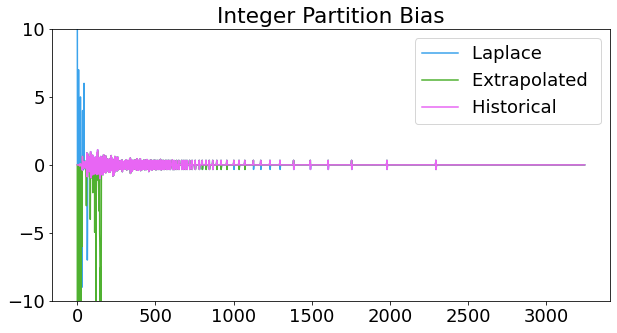

In [ ]:
plt.plot(ls_bias, c=l_color,alpha=1, label=l_label)
plt.plot(ps_bias, c=p_color,alpha=1, label=p_label)
plt.plot(hs_bias, c=h_color,alpha=1, label=h_label)
plt.ylim(-10,10)
plt.legend()
plt.title("Integer Partition Bias")
plt.show()

Interestingly, although the Historical Benchmark bounds are not centered on the true counts, they still result in a relatively un-biased output compared with the predicted and Laplace bounds. This may be due to the historical bounds being wider for larger counts than the other two strategies.

### Absolute Error
The bias gives a sense of whether there are consistent directional errors. We now analyze the absolute (unsigned) error.

In [ ]:
def get_abs_err(l):
  err = []
  for i in range(0, len(true_counts)):
    abs_err = 0
    for j in range(0, len(l)):
      abs_err += abs(l[j][i] - true_counts[i])
    err.append(abs_err/len(l))
  return err

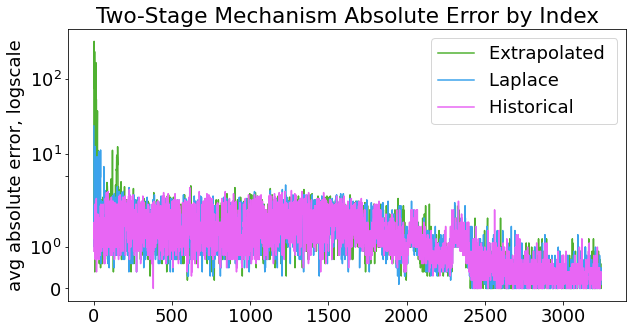

Predicted scoped avg dist:  13651.599999999997
Predicted basic avg dist:  5538.600000000016
Laplace scoped avg dist:  6851.900000000028
Laplace basic avg dist:  3731.2999999999975
Historical scoped avg dist:  10056.300000000005
Historical basic avg dist:  3695.4999999999927


In [ ]:
ls_err = []
lb_err = []
for i in range(0, len(true_counts)):
  abs_err = 0
  for j in range(0, len(ls_attr)):
    abs_err += abs(ls_attr[j][i] - true_counts[i])
  ls_err.append(abs_err)
lb_err = get_abs_err(lb_attr)

pb_err = get_abs_err(pb_attr)
plt.plot(pb_err, c=p_color,label=p_label)#,alpha=0.5)
ps_err = get_abs_err(ps_attr)

lb_err = get_abs_err(lb_attr)
plt.plot(lb_err, c=l_color,label=l_label)#,alpha=0.5)
ls_err = get_abs_err(ls_attr)

hb_err = get_abs_err(hb_attr)
plt.plot(hb_err, c=h_color,label=h_label)#,alpha=0.5)
hs_err = get_abs_err(hs_attr)

plt.yscale('symlog')
plt.yticks([0,1,5,10,100])
plt.ylabel("avg absolute error, logscale")
plt.legend()
plt.title("Two-Stage Mechanism Absolute Error by Index")
plt.show()
print("Predicted scoped avg dist: ",sum(ps_err))
print("Predicted basic avg dist: ",sum(pb_err))
print("Laplace scoped avg dist: ",sum(ls_err))
print("Laplace basic avg dist: ",sum(lb_err))
print("Historical scoped avg dist: ",sum(hs_err))
print("Historical basic avg dist: ",sum(hb_err))

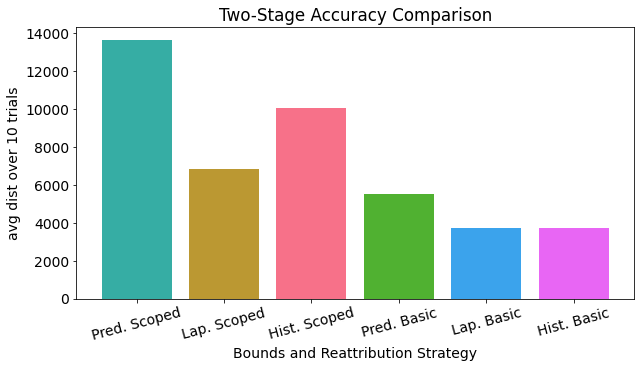

In [ ]:
height = [sum(ps_err), sum(ls_err), sum(hs_err),sum(pb_err),  sum(lb_err), sum(hb_err)]
bars = ('Extr. Scoped', 'Lap. Scoped', 'Hist. Scoped','Extr. Basic',  'Lap. Basic',  'Hist. Basic')
y_pos = np.arange(6)
plt.bar(y_pos, height, color=[ps_color,ls_color, hs_color,p_color, l_color,h_color])
plt.xticks(y_pos, bars,rotation='15')
plt.ylabel("avg dist over 10 trials")
plt.xlabel("Bounds and Reattribution Strategy")
plt.title("Two-Stage Accuracy Comparison")
plt.show()

Compared with a total cell count of $\approx 3200$, these errors are quite good.

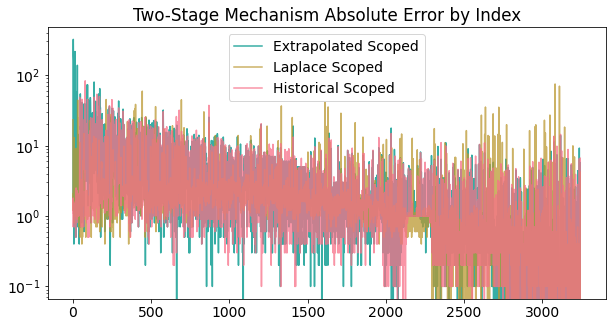

In [ ]:
pb_err = get_abs_err(pb_attr)

ps_err = get_abs_err(ps_attr)
plt.plot(ps_err, c=ps_color,linestyle="-",label=p_label + "Scoped")

lb_err = get_abs_err(lb_attr)

ls_err = get_abs_err(ls_attr)
plt.plot(ls_err, c=ls_color,linestyle="-",label=l_label + "Scoped",alpha=.75)

hb_err = get_abs_err(hb_attr)

hs_err = get_abs_err(hs_attr)
plt.plot(hs_err, c=hs_color,linestyle="-",label=h_label + "Scoped",alpha=0.75)

plt.legend()

plt.yscale('log')
plt.title("Two-Stage Mechanism Absolute Error by Index")
plt.show()

A small sample of the first trial output from each strategy versus the true counts.

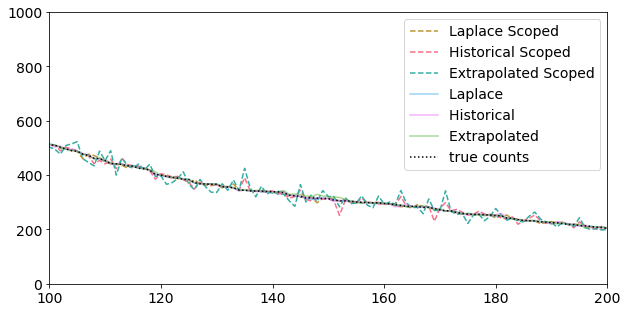

In [ ]:

for i in range(0, 1):#len(ls_attr)):
  plt.plot(ls_attr[i],c=ls_color, linestyle="--", label=l_label + "Scoped")#, alpha=0.5)
  plt.plot(hs_attr[i],c=hs_color, linestyle="--", label=h_label + "Scoped")#, alpha=0.5)
  plt.plot(ps_attr[i],c=ps_color, linestyle="--", label=p_label + "Scoped")#, alpha=0.5)
  plt.plot(lb_attr[i],c=l_color,alpha=0.5, label=l_label)
  plt.plot(hb_attr[i],c=h_color,alpha=0.5, label=h_label)
  plt.plot(pb_attr[i],c=p_color,alpha=0.5, label=p_label)

plt.plot(true_counts,c='k',linestyle=':',label="true counts")
plt.legend()
plt.xlim(100,200)
plt.ylim(0,1000)
plt.title("Sample Outputs vs True Counts")
plt.show()

### Discussion
Interestingly, the most basic bounds which use no additional budget seem to perform the best (or at least as good as the Laplace bounds). This is a great example of why using a private mechanism selection algorithm may be useful in practice, as it can help to identify cases when simple "free" bounds based on historical data actually work well. In practice, one would also probably apply **sparsity control** to the Laplace bounds (which is available in the demo binary), which would reduce the wide bounds in the tail for Laplace to a more realistic width.


Furthermore, it's very interesting that the scoped re-attribution (which uses the information from the bounds to scope the outcome space in re-attribution) does not improve performance. We hypothesize that scoped re-attribution is ineffective because the provided bounds aren't very good for the *names* themselves, although they are very good for the *partition*. That is, the bounds describe the shape of the partition very well, but don't do as good of a job describing the values for the names in order.